In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd
import numpy as np
import os, sys
import h5py

from sklearn.metrics import precision_recall_fscore_support

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
def load_embeddings(source):
    file = open(source, 'rb')
    hf = h5py.File(file)
    att = hf['att'][()]
    x = hf['x'][()]
    t = hf['t'][()]
    lc = np.concatenate([t, x], 2)
    y = hf['y'][()]
    l = hf['l'][()]
    m = 1. - hf['m'][()]
    return att, y, l, m, lc

In [3]:
def get_prediction(data, folder, name):
    x, y, l, m, lc = load_embeddings(os.path.join(data, 'test.h5'))
    
    if name == 'lstm':
        x_test = lc
    if name == 'lstm_att':
        x_test = x
    if name == 'mlp_att':
        x_test = np.sum(x*m, 1)/l[:,None]
        
    model = tf.keras.models.load_model(os.path.join(folder, name, 'model'))
    y_pred = model.predict(x_test)
    y_pred = tf.argmax(y_pred, 1)
    
    return y, y_pred

In [4]:
exp_name = 'ogle'

results = []
for exp in ['{}_20'.format(exp_name), 
            '{}_50'.format(exp_name), 
            '{}_100'.format(exp_name),
            '{}_500'.format(exp_name),
            '{}'.format(exp_name)]:
    
    for model_name in ['lstm', 'lstm_att', 'mlp_att']:
        y, y_pred = get_prediction('../../embeddings/{}'.format(exp), 
                                   '../../experiments/{}'.format(exp), 
                                   model_name)

        prec, reca, f1, _ = precision_recall_fscore_support(y, y_pred, average='macro')
        
        results.append([exp, model_name, f1, prec, reca])

2021-11-08 12:05:55.347052: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-08 12:05:55.347088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pececillo
2021-11-08 12:05:55.347094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pececillo
2021-11-08 12:05:55.347179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.74.0
2021-11-08 12:05:55.347196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.74.0
2021-11-08 12:05:55.347201: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.74.0
2021-11-08 12:05:55.347386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

In [5]:
df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
df_results

,exp,model,f1,recall,precision
0,ogle_20,lstm,0.106782,0.083143,0.171429
1,ogle_20,lstm_att,0.365515,0.390556,0.401190
2,ogle_20,mlp_att,0.462009,0.528030,0.460913
3,ogle_50,lstm,0.083069,0.064088,0.143607
4,ogle_50,lstm_att,0.501505,0.527045,0.535668
5,ogle_50,mlp_att,0.497259,0.506264,0.504079
6,ogle_100,lstm,0.120703,0.101597,0.169206
7,ogle_100,lstm_att,0.479791,0.493071,0.490662
8,ogle_100,mlp_att,0.525984,0.538487,0.521783
9,ogle_500,lstm,0.111450,0.317339,0.155746


lstm
lstm_att
mlp_att


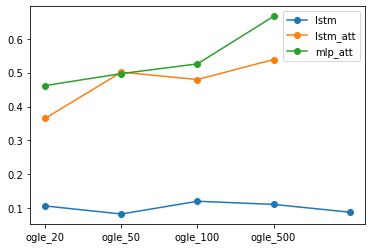

In [7]:
for exp, group in df_results.groupby('model'):
    print(exp)
    xrange = range(len(group['exp']))
    plt.plot(xrange, group['f1'], marker='o',label=exp)
    plt.xticks(xrange, group['exp'])
plt.legend()
plt.show()